In [1]:
import pytorch_lightning as pl
from torch import nn
import torch
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\models\self_supervised\amdim\amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\models\self_superv

In [2]:
def generate_label_channel(labels, height=32, width=32, device = None):
    batch_size = len(labels)
    matrices = torch.zeros((batch_size, 1, height, width), device=device)    
    for i, label in enumerate(labels):
        matrices[i, 0, :, label] = 1    
    return matrices


In [3]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32, input_channels=4 ):
        super().__init__()
        self.save_hyperparameters()
        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.encoder.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )
        self.decoder.conv1 = nn.Conv2d(64 , input_channels, kernel_size=3, stride=1, padding=1, bias=False)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl


    def merge_batch_and_label_channel(self, batch):
        x, label = batch
        _, _, height, width = x.shape
        label_channel = generate_label_channel(label, height, width, self.device )
        x_with_label = torch.cat((x, label_channel), dim=1)
        return x_with_label 

    def forward(self, batch):     
        
        # Concatenate image and label channel
        x_with_label = self.merge_batch_and_label_channel(batch)
        
        # Encode the input
        encoded = self.encoder(x_with_label)
        
        # Get mu and log_var from encoded representation
        mu, log_var = self.fc_mu(encoded), self.fc_var(encoded)
        
        # Sample z from the distribution
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        
        # Decode z
        x_hat = self.decoder(z)
        
        return x_hat, mu, std, z

    def training_step(self, batch, batch_idx):
        
        x_with_label = self.merge_batch_and_label_channel(batch)
        
        # Forward pass
        x_hat, mu, std, z = self(batch)
        
        # Reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x_with_label)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

In [4]:
from pl_bolts.datamodules import CIFAR10DataModule
datamodule = CIFAR10DataModule('data')

In [5]:
pl.seed_everything(1234)
vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=25)
trainer.fit(vae, datamodule=datamodule)

Global seed set to 1234
C:\Users\1430647\AppData\Local\Temp\1\ipykernel_40168\328198708.py:6: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\models\autoencoders\components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
c:\Users\1430647\Anac

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.233    Total estimated model params size (MB)
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


In [6]:
trainer.save_checkpoint("results/cifar10_vae_final_checkpoint.ckpt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.035990905..1.1164712].


x_hat shape: torch.Size([1, 4, 32, 32])
mu shape: torch.Size([1, 256])
std shape: torch.Size([1, 256])
z shape: torch.Size([1, 256])
x_hat_rgb shape: torch.Size([1, 3, 32, 32])


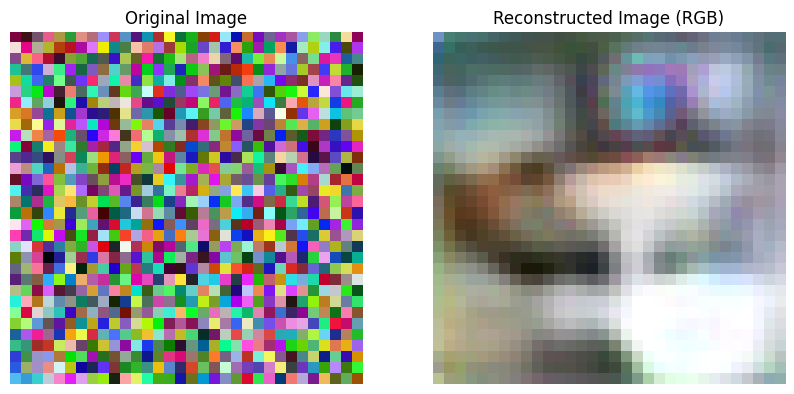

In [7]:
# DATA
# we're pretending to have an image from cifar-10 (3 channels, 32x32 pixels)
x = torch.rand(1, 3, 32, 32).to(vae.device)
dummy_label = torch.zeros(1, dtype=torch.long).to(vae.device)
dummy_batch = (x, dummy_label)

with torch.no_grad():
    x_hat, mu, std, z = vae(dummy_batch)

print('x_hat shape:', x_hat.shape)
print('mu shape:', mu.shape)
print('std shape:', std.shape)
print('z shape:', z.shape)  

# Show x_hat without the 4th channel
x_hat_rgb = x_hat[:, :3]  # Select only the first 3 channels (RGB)
print('x_hat_rgb shape:', x_hat_rgb.shape)

# Optionally, you can visualize the reconstructed image
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[0, :3].permute(1, 2, 0).cpu().numpy())
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_hat_rgb[0].permute(1, 2, 0).cpu().detach().numpy())
plt.title('Reconstructed Image (RGB)')
plt.axis('off')

plt.show()



In [8]:
from torchsummary import summary
vae = VAE.load_from_checkpoint("results/cifar10_vae_final_checkpoint.ckpt")
vae.eval().to(torch.device("cuda"))

# Print number of parameters
total_params = sum(p.numel() for p in vae.parameters())
trainable_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")



C:\Users\1430647\AppData\Local\Temp\1\ipykernel_40168\328198708.py:6: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
c:\Users\1430647\Anaconda3\envs\cuda\lib\site-packages\pl_bolts\models\autoencoders\components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
c:\Users\1430647\Anaconda3\envs\cuda\lib\site


Total parameters: 20,058,241
Trainable parameters: 20,058,241


In [25]:
def execute_model_and_plot(vae, images, labels):
    # Generate reconstructions
    with torch.no_grad():
        x_hat, _, _, _ = vae((images, labels))

    # Remove the label channel from reconstructions
    x_hat = x_hat[:, :3]

    # Plot original and reconstructed images
    fig, axes = plt.subplots(4, 10, figsize=(20, 8))

    for i in range(20):
        # Original image
        ax = axes[i // 10 * 2, i % 10]
        ax.imshow(images[i].cpu().permute(1, 2, 0))
        ax.axis('off')
        if i % 10 == 0:
            ax.set_title('Original', fontsize=10)

        # Reconstructed image
        ax = axes[i // 10 * 2 + 1, i % 10]
        ax.imshow(x_hat[i].cpu().permute(1, 2, 0).clamp(0, 1))
        ax.axis('off')
        if i % 10 == 0:
            ax.set_title('Reconstructed', fontsize=10)

    plt.tight_layout()
    plt.show()

def execute_model_and_plot(vae, images, labels):
    # Generate reconstructions
    with torch.no_grad():
        x_hat, _, _, _ = vae((images, labels))

    # Remove the label channel from reconstructions
    x_hat = x_hat[:, :3]

    # Get the batch size
    batch_size = images.shape[0]

    # Calculate the number of rows needed
    num_rows = (batch_size + 9) // 10  # Round up to the nearest multiple of 10

    # Plot original and reconstructed images
    fig, axes = plt.subplots(num_rows * 2, 10, figsize=(20, 4 * num_rows))

    for i in range(batch_size):
        # Original image
        ax = axes[i // 10 * 2, i % 10]
        ax.imshow(images[i].cpu().permute(1, 2, 0))
        ax.axis('off')
        if i % 10 == 0:
            ax.set_title('Original', fontsize=10)

        # Reconstructed image
        ax = axes[i // 10 * 2 + 1, i % 10]
        ax.imshow(x_hat[i].cpu().permute(1, 2, 0).clamp(0, 1))
        ax.axis('off')
        if i % 10 == 0:
            ax.set_title('Reconstructed', fontsize=10)

    # Turn off any unused subplots
    for i in range(batch_size, num_rows * 10):
        axes[i // 10 * 2, i % 10].axis('off')
        axes[i // 10 * 2 + 1, i % 10].axis('off')

    plt.tight_layout()
    plt.show()


In [14]:
def replace_label(labels, old_label, new_label):
    new_labels = labels.clone()
    new_labels[labels == old_label] = new_label
    return new_labels

In [33]:

cifar10_dm = CIFAR10DataModule(data_dir='./data', batch_size=10, num_workers=4)
cifar10_dm.setup(stage='test')
test_loader = cifar10_dm.test_dataloader()
test_loader_iter = iter(test_loader)

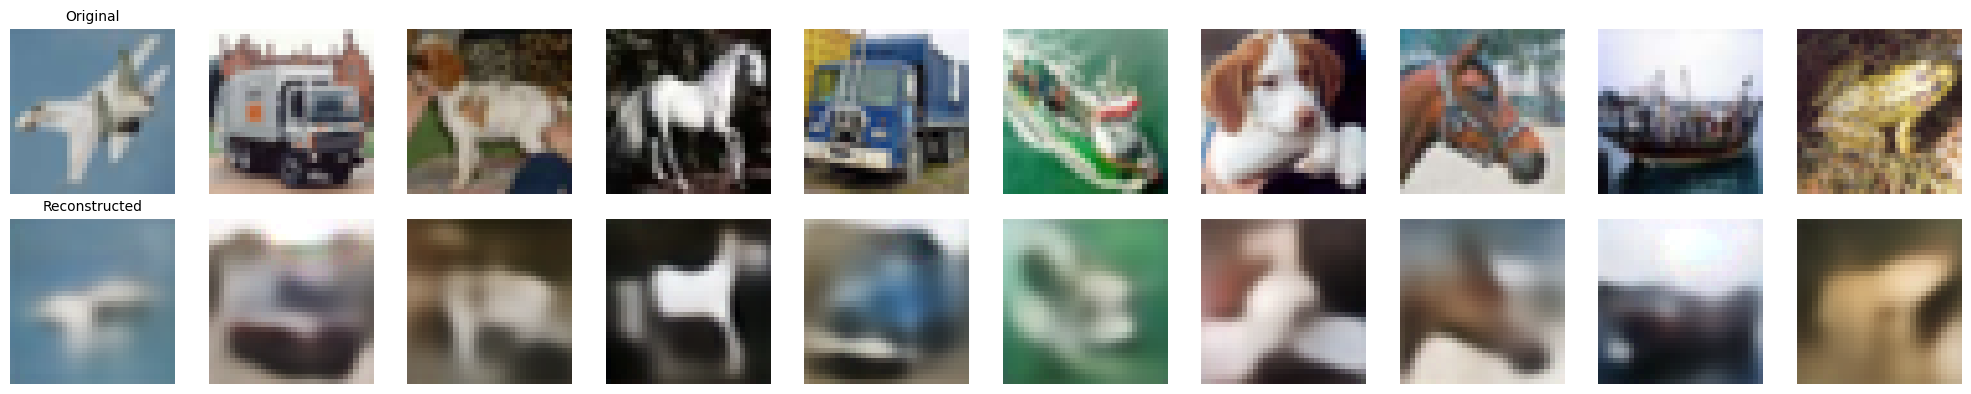

In [35]:
# Get a batch of images
images, labels = next(test_loader_iter)
images = images.to(vae.device)
labels = labels.to(vae.device)
# Call the function
execute_model_and_plot(vae, images, labels)

horse -> truck
tensor([0, 9, 5, 7, 9, 8, 5, 7, 8, 6], device='cuda:0')
tensor([0, 9, 5, 9, 9, 8, 5, 9, 8, 6], device='cuda:0')


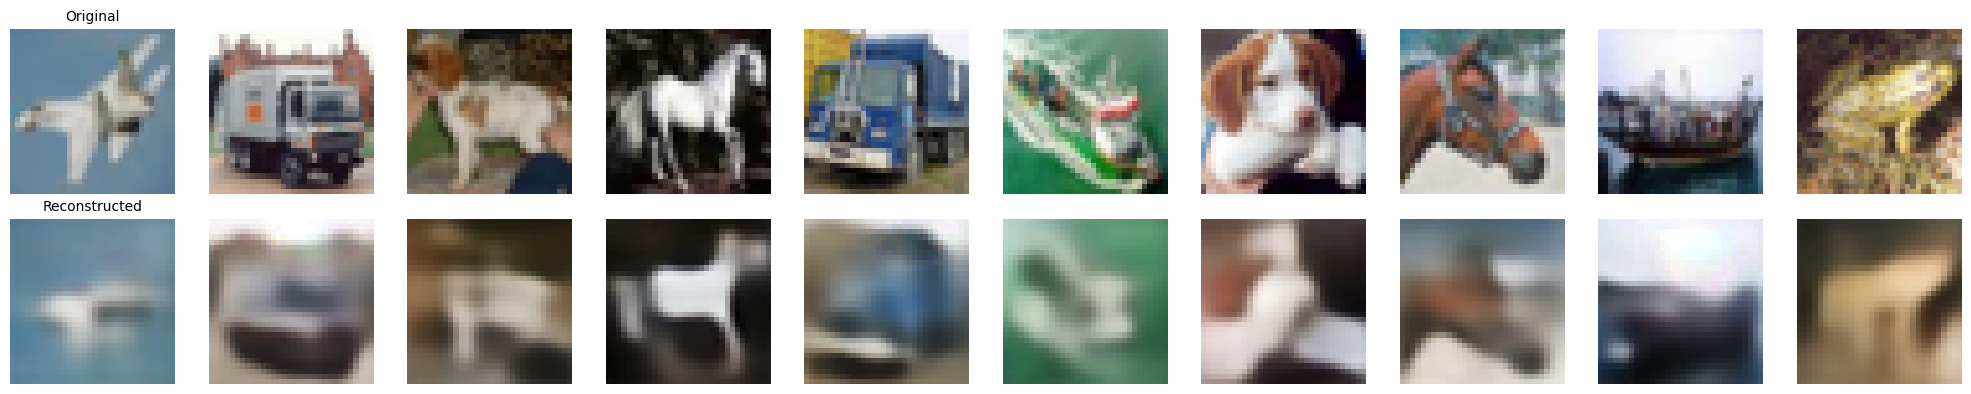

In [40]:
# Get the class names for CIFAR-10
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print the names of the labels for the current batch
# print("Labels for the current batch:")
# for label in labels:
#     print(cifar10_classes[label])

# We are replacing labels
# replacing horse with bird
old_label = 7
new_label = 9
print(f"{cifar10_classes[old_label]} -> {cifar10_classes[new_label]}") 
new_labels = replace_label(labels, old_label, new_label)
print(labels)
print(new_labels)
execute_model_and_plot(vae, images, new_labels)

In [42]:
# from torchvision.utils import save_image

# output_image_path = 'results/assignment-22-cifar10-vae.png'
# comparison = torch.cat([images, x_hat])
# save_image(comparison.cpu(), output_image_path)

In [41]:
# from PIL import Image
# import matplotlib.pyplot as plt
# Open the image
# img = Image.open(output_image_path)
# # Display the image
# plt.imshow(img)
# plt.axis('off')  # Hide axes for better visualization
# plt.show()
